We are testing the performance of different attack parameters below, using the actions and clean observations from the optimal BB attack. Because the ASR was 1 we effectively have a sample and label for every timestep, where the previous action lead to the next clean observation. We can treat this as a supervised learning problem since we effectively have a label for each observation/sample. Unlike the untargeted attack, the actions are not chsen randomly. Given that CityLearn is deterministic we expect that the optinal adversarial trace is also deterministic (confirm with multiple runs) in terms of the action associated with each observation. 

From below: 
- Does the vecorized search work for more than one sample input at the same time (that's how their input for rl, here it gets thousands at a time)
- Increasing the batchsize has a significant effect on speed
- we don't have an init for action 18, does that correspond to the incorrect preds?

This copy used ramdoms.uniform in mybb, which didn't cause any changes

In [14]:
AGENT_NAME = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_500.zip'
ATTACK = 'myBB'


In [15]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from KBMproject.mybb import BrendelBethgeAttack as BBA

import pandas as pd
import numpy as np
import os

import KBMproject.utilities as utils

from joblib import Parallel, delayed

%matplotlib inline

In [16]:
import logging
logging.basicConfig(level=logging.WARN)

Define RL agent

In [17]:
agent = PPO.load(path=f"{AGENT_NAME}")
print('Model loaded from storage')

Model loaded from storage


In [18]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
victim_policy = classifier(
    model=utils.extract_actor(agent),
    loss=CrossEntropyLoss(), 
    nb_classes=agent.action_space[0].n,
    input_shape=agent.observation_space.shape,
    device_type='gpu',
    clip_values = (agent.observation_space.low.min(),agent.observation_space.high.max()) #min and max values of each feature, brendle bethge attack only supports floats values and not array
    )

In [19]:
mask_time = np.ones(agent.observation_space.shape)
mask_time[:6] = 0

In [20]:
df_baseline = pd.concat([pd.read_csv('baseline_obs.csv', index_col=0,dtype='float32'),
                        pd.read_csv('baseline_obs_a_confidence.csv', index_col=0)], axis='columns')

Below, for each action we select the sample with the highest logit softmax/confidence

In [21]:
df_max_confidence_samples = df_baseline.loc[df_baseline.groupby('action')['confidence'].idxmax()]
df_max_confidence_samples = df_max_confidence_samples.drop(columns='confidence')
df_max_confidence_samples = df_max_confidence_samples.set_index('action')

In [22]:
dict_samples = df_max_confidence_samples.T.to_dict()

In [23]:
samples = pd.read_csv('bb results/optimal myBB observations.csv', index_col=0,dtype='float32')

In [24]:
inputs = samples.to_numpy()[:-1]

In [25]:
targets = np.argmax(victim_policy.predict(pd.read_csv('bb results/optimal myBB adversarial observations.csv',
                                            index_col=0,
                                            dtype='float32')
                                            ), axis=1)

In [26]:
starts = np.array([np.array(list(
    dict_samples[a].values())).astype('float32') if a in dict_samples else np.zeros(agent.observation_space.shape, 'float32') for a in targets]) #there is no example for action 18

Kwards from the first 100 Optuna trials

In [27]:
kwargs = dict(norm=2,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=2e-2,
        lr_decay=0.45,
        lr_num_decay=25,
        momentum=0.98,
        binary_search_steps=20,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        #batch_size=1, this makes it soooooo much worse, increasing it to 1000 seems to sligthly decrease the computation time
        )
optuna_attack = BBA(estimator=victim_policy, **kwargs)

In [ ]:
%%time
optuna_adv_samples = optuna_attack.generate(x=inputs, 
                         y=targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

In [ ]:
optuna_adv_preds = np.argmax(victim_policy.predict(optuna_adv_samples), axis=1)

ASR

In [ ]:
np.count_nonzero(optuna_adv_preds == targets)/optuna_adv_samples.shape[0]

0.991894051832401

In [ ]:
adv_diff = optuna_adv_samples - inputs
df_norms = pd.DataFrame({'L2':np.linalg.norm(adv_diff, ord=2, axis=1),
                         'Linf':np.linalg.norm(adv_diff, ord=np.inf, axis=1)})

<Axes: title={'center': 'KDE of norms for an L2 BB Attack'}, ylabel='Density'>

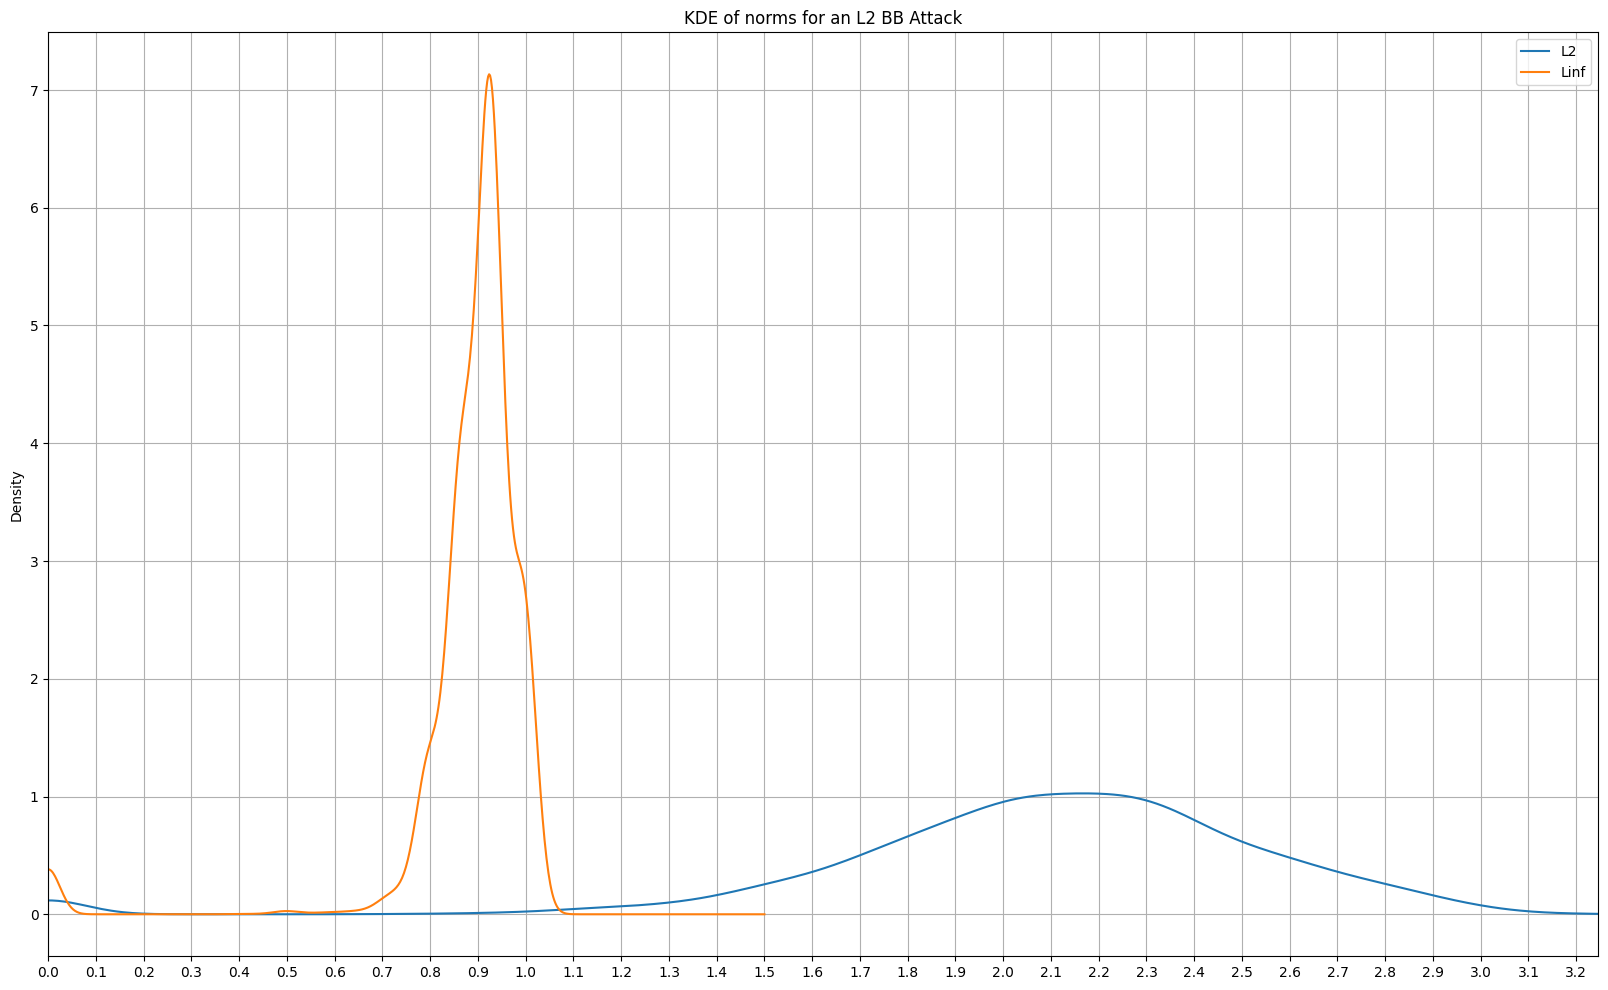

In [ ]:
df_norms.plot.kde(grid=True, 
                   xticks=np.arange(start=df_norms.min().min(), stop=df_norms.max().max(), step=0.1),
                   figsize=(20,12),
                   xlim=[df_norms.min().min(),df_norms.max().max()], #NB the max/min of a df is a series, and we need the max/min of the series
                   title='KDE of norms for an L2 BB Attack',
                   xlabel='Linf Norms',
                   legend=True
                   )

kwargs from the next 50 trials

In [29]:
kwargs = dict(norm=2,
        targeted=True, #default false
        overshoot=1.1, #1.1,
        steps=1000,
        lr=2.1e-2,
        lr_decay=0.45,
        lr_num_decay=34,
        momentum=1.0,
        binary_search_steps=20,
        init_size=1_000_000, #default 100, finds sample matching the target class through iterative random search
        #batch_size=1, this makes it soooooo much worse, increasing it to 1000 seems to sligthly decrease the computation time
        )
optuna_attack = BBA(estimator=victim_policy, **kwargs)

In [30]:
%%time
optuna_adv_samples = optuna_attack.generate(x=inputs, 
                         y=targets, 
                         x_adv_init=starts, 
                         mask=mask_time)

CPU times: total: 53min 59s
Wall time: 17min 54s


In [31]:
optuna_adv_preds = np.argmax(victim_policy.predict(optuna_adv_samples), axis=1)

ASR

In [32]:
np.count_nonzero(optuna_adv_preds == targets)/optuna_adv_samples.shape[0]

0.9997716634318986

In [35]:
adv_diff = optuna_adv_samples - inputs
df_norms = pd.DataFrame({'L2':np.linalg.norm(adv_diff, ord=2, axis=1),
                         'Linf':np.linalg.norm(adv_diff, ord=np.inf, axis=1)})

In [38]:
df_norms.describe()

,L2,Linf
count,8759.000000,8759.000000
mean,2.084003,0.884491
std,0.495628,0.151828
min,0.000000,0.000000
25%,1.866281,0.866025
50%,2.130622,0.922742
75%,2.379815,0.933012
max,3.245887,1.000000


<Axes: title={'center': 'KDE of norms for an L2 BB Attack'}, ylabel='Density'>

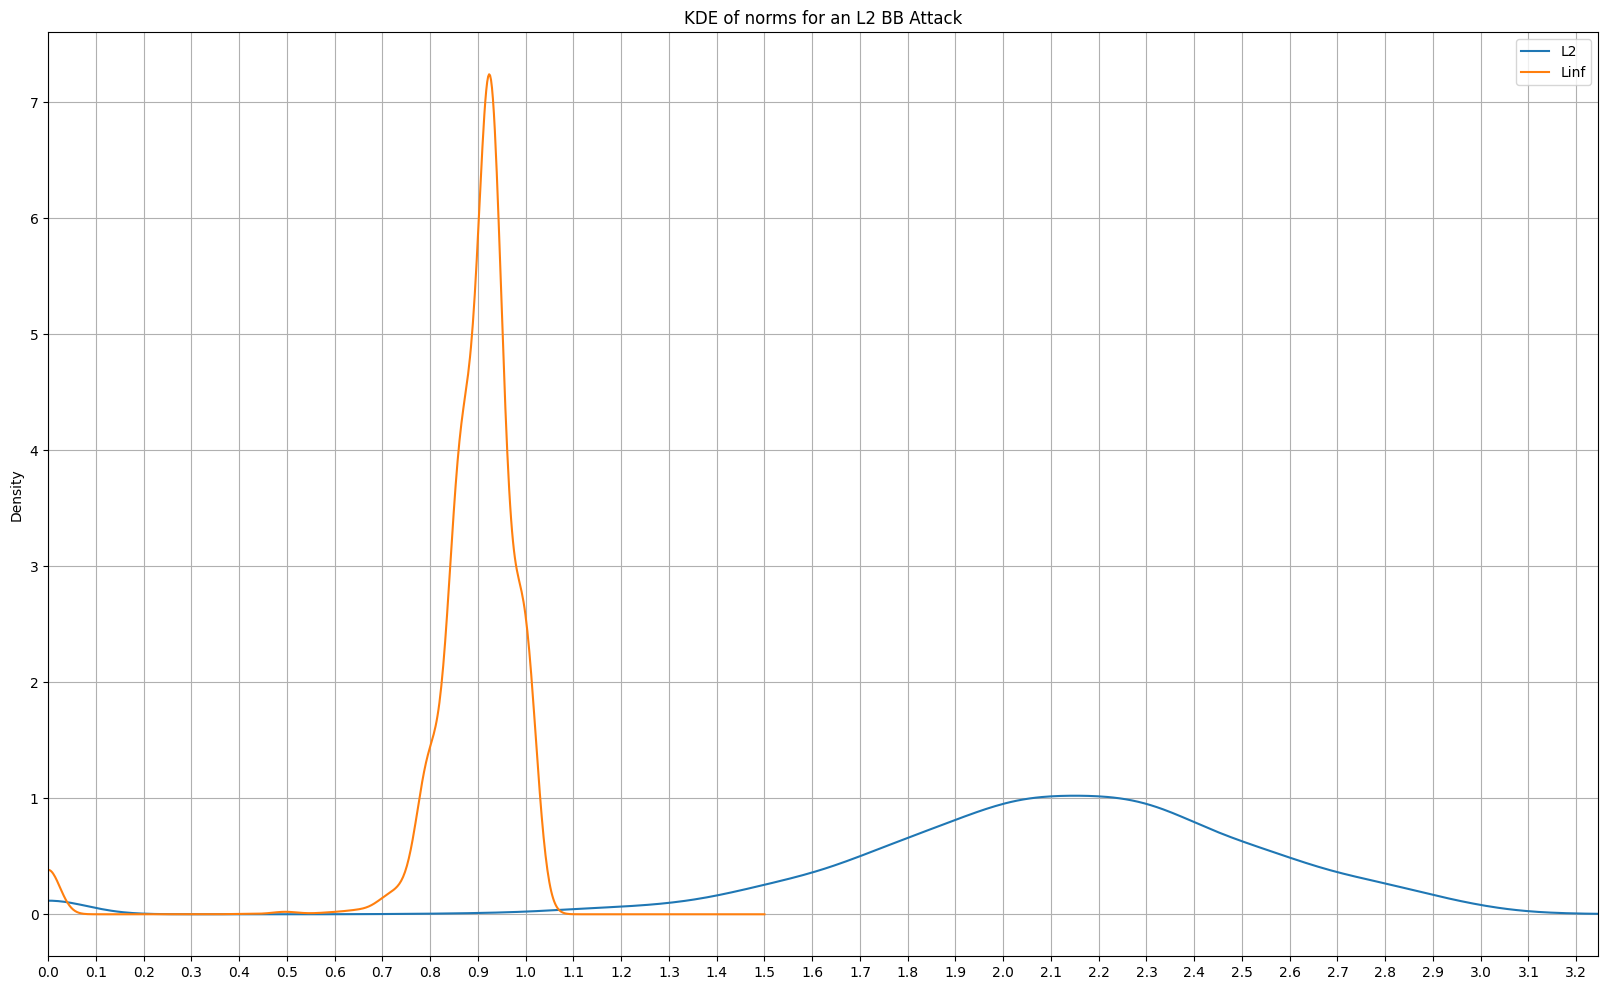

In [36]:
df_norms.plot.kde(grid=True, 
                   xticks=np.arange(start=df_norms.min().min(), stop=df_norms.max().max(), step=0.1),
                   figsize=(20,12),
                   xlim=[df_norms.min().min(),df_norms.max().max()], #NB the max/min of a df is a series, and we need the max/min of the series
                   title='KDE of norms for an L2 BB Attack',
                   xlabel='Linf Norms',
                   legend=True
                   )

We see that the accuracy has improved but the norm is drastically larger, perhaps decreasing the penaulty will solve this issue. Unsuccessful samples where assigned a norm of 10x the max norm, which may mask the signal from decreasing norms overall. The other issue could be that the starting points result in larger norms compared to those found witha random search. 